<a href="https://colab.research.google.com/github/flohmannjr/Heart-Attack-Analysis-and-Prediction/blob/main/Heart_Attack_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Attack Analysis and Prediction

https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import SGD

# Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

SEED = 0

SEX_LABELS = ['Female', 'Male']

## TensorFlow hyperparameters

In [3]:
BATCH_SIZE = 32

LAYERS = 4

LAYER_UNITS       = 120
LAYER_INITIALIZER = 'he_uniform'
LAYER_ACTIVATION  = 'relu'

OUTPUT_UNITS      = 1
OUTPUT_ACTIVATION = 'sigmoid'

LOSS          = 'binary_crossentropy'
OPTIMIZER     = SGD
LEARNING_RATE = 0.001
METRICS       = [Recall()]

EPOCHS = 1000

## Functions

In [4]:
def get_df_output(feature):

    if(type(feature) == list):
        features = feature.copy()
    else:
        features = []
        features.append(feature)

    features.append('output')

    df_output = df[features].groupby(by=feature).agg(['count', 'sum', 'mean'])

    # df_output.columns = ['_'.join(col) for col in df_output.columns.values]
    df_output.columns = df_output.columns.get_level_values(1)

    df_output.reset_index(inplace=True)

    return df_output

In [5]:
def heart_attack_by_sex(feature, xlabel, xtickslabels=None):

    df_output = get_df_output([feature, 'sex'])

    ax = sns.barplot(data=df_output, x=feature, y='mean', hue='sex', palette='summer_r')

    plt.title('')
    plt.xlabel(xlabel)
    plt.ylabel('Chance of heart attack ratio')

    if xtickslabels != None:
        plt.xticks(ticks=range(len(xtickslabels)), labels=xtickslabels)

    # sns.barplot has a bug about losing legend colors if you don't inform handles and labels together.
    handles, _ = ax.get_legend_handles_labels()

    plt.legend(loc=(1.03, 0.88), frameon=True, facecolor='white', handles=handles, labels=SEX_LABELS)

    plt.show()

In [6]:
def evaluate_model(y_true, y_pred, show_reports=False, cmap='summer_r'):

    if show_reports:
        print(classification_report(y_true, y_pred))

        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=cmap)
        plt.grid(False)

    report = classification_report(y_true, y_pred, output_dict=True)

    return {'accuracy': report['accuracy'],
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1-score': report['weighted avg']['f1-score']}

In [7]:
def get_ensemble(train_data, validation_data, n_models=10):

    ensemble_models = []

    for m in range(n_models):

        model = Sequential()

        [model.add(Dense(units=LAYER_UNITS, kernel_initializer=LAYER_INITIALIZER, activation=LAYER_ACTIVATION)) for _ in range(LAYERS)]
        model.add(Dense(units=OUTPUT_UNITS, activation=OUTPUT_ACTIVATION))

        model.compile(loss=LOSS,
                      optimizer=OPTIMIZER(learning_rate=LEARNING_RATE),
                      metrics=METRICS)

        model.fit(dataset_train,
                  epochs=EPOCHS,
                  validation_data=dataset_test,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
                             ReduceLROnPlateau(monitor='val_loss', patience=50)],
                  verbose=0)
        
        ensemble_models.append(model)

    return ensemble_models

def get_preds(ensemble_models, validation_data):
    
    ensemble_preds = []

    for model in ensemble_models:
        ensemble_preds.append(model.predict(validation_data, verbose=0))
    
    return tf.constant(tf.squeeze(ensemble_preds))

# Data

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/Heart-Attack-Analysis-and-Prediction/main/heart.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


**Source**: Kaggle dataset and discussions

* **age**: Age of the patient
* **sex**: Sex of the patient
    * 0 = female
    * 1 = male
* **cp**: Chest Pain type chest pain type
    * 0 = asymptomatic
    * 1 = typical angina
    * 2 = atypical angina
    * 3 = non-anginal pain
* **trtbps**: resting blood pressure (in mm Hg)
* **chol**: cholesterol in mg/dl fetched via BMI sensor
* **fbs**: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
* **restecg**: resting electrocardiographic results
    * 0 = normal
    * 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
* **thalachh**: maximum heart rate achieved
* **exng**: exercise induced angina (1 = yes; 0 = no)
* **oldpeak**: ST depression induced by exercise relative to rest
* **slp**: the slope of the peak exercise ST segment
    * 0 = downsloping
    * 1 = flat
    * 2 = upsloping
* **caa**: number of major vessels (0-3) colored by flourosopy
    * 4 = *null*
* **thall**: thalium stress test result
    * 0 = *null*
    * 1 = fixed defect
    * 2 = normal
    * 3 = reversable defect
* **output**: diagnosis of heart disease (angiographic disease status)
    * 0 = < 50% diameter narrowing (less chance of heart attack)
    * 1 = > 50% diameter narrowing (more chance of heart attack)


## Preprocessing

In [10]:
# Drop rows with 'caa' = 4 = null
df.drop(df[df['caa'] == 4].index, inplace=True)

# Drop rows with 'thall' = 0 = null
df.drop(df[df['thall'] == 0].index, inplace=True)

In [11]:
# Checking for duplicates
df.duplicated().sum()

0

In [12]:
df['age_group']      = (np.ceil(df['age'] / 10) * 10).astype(int)
df['trtbps_group']   = (np.ceil(df['trtbps'] / 10) * 10).astype(int)
df['chol_group']     = (np.ceil(df['chol'] / 50) * 50).astype(int)
df['thalachh_group'] = (np.ceil(df['thalachh'] / 10) * 10).astype(int)
df['oldpeak_group']  = (np.ceil(df['oldpeak'])).astype(int)

In [13]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group,trtbps_group,chol_group,thalachh_group,oldpeak_group
count,296.000000,296.000000,296.000000,296.00000,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,54.523649,0.679054,0.959459,131.60473,247.155405,0.14527,0.523649,149.560811,0.327703,1.059122,1.395270,0.679054,2.327703,0.540541,59.155405,133.817568,271.959459,154.324324,1.358108
std,9.059471,0.467631,1.034184,17.72662,51.977011,0.35297,0.526692,22.970792,0.470171,1.166474,0.618235,0.939726,0.585743,0.499198,9.073868,17.734974,55.456916,23.132988,1.294107
min,29.000000,0.000000,0.000000,94.00000,126.000000,0.00000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,30.000000,100.000000,150.000000,80.000000,0.000000
25%,48.000000,0.000000,0.000000,120.00000,211.000000,0.00000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,50.000000,120.000000,250.000000,140.000000,0.000000
50%,56.000000,1.000000,1.000000,130.00000,242.500000,0.00000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,60.000000,130.000000,250.000000,160.000000,1.000000
75%,61.000000,1.000000,2.000000,140.00000,275.250000,0.00000,1.000000,166.000000,1.000000,1.650000,2.000000,1.000000,3.000000,1.000000,70.000000,140.000000,300.000000,170.000000,2.000000
max,77.000000,1.000000,3.000000,200.00000,564.000000,1.00000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000,80.000000,200.000000,600.000000,210.000000,7.000000


In [14]:
df[:5]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group,trtbps_group,chol_group,thalachh_group,oldpeak_group
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,70,150,250,150,3
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,40,130,250,190,4
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,50,130,250,180,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,60,120,250,180,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,60,120,400,170,1


# Analysis

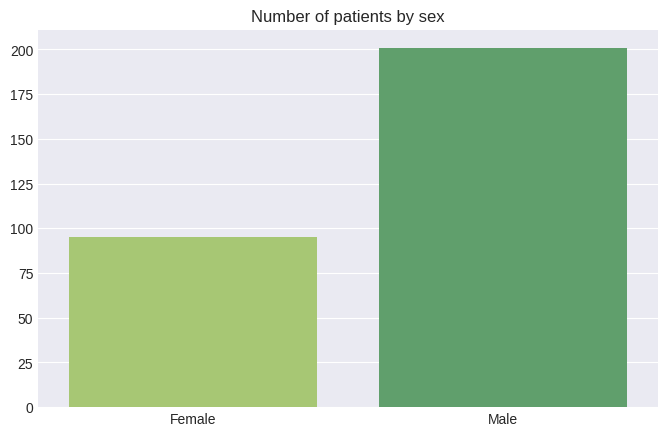

In [15]:
sexes = pd.DataFrame(df['sex'].value_counts().sort_index())

ax = sns.barplot(data=sexes, x=sexes.index, y='sex', palette='summer_r')

plt.title('Number of patients by sex')
plt.xlabel('')
plt.ylabel('')

plt.xticks(ticks=range(len(SEX_LABELS)), labels=SEX_LABELS);

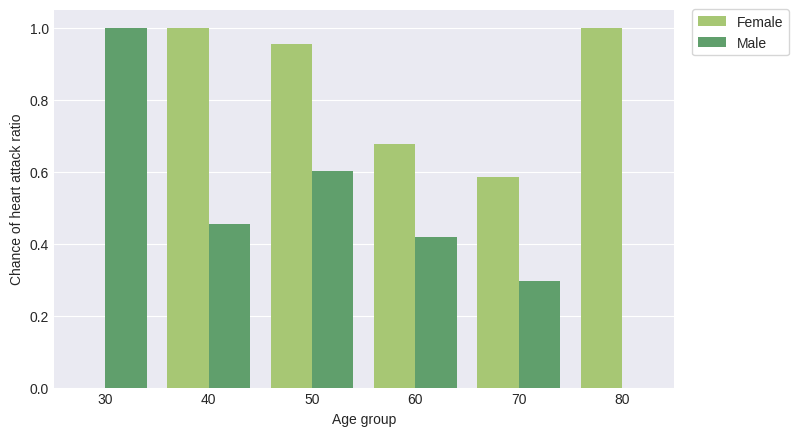

In [16]:
heart_attack_by_sex('age_group', 'Age group')

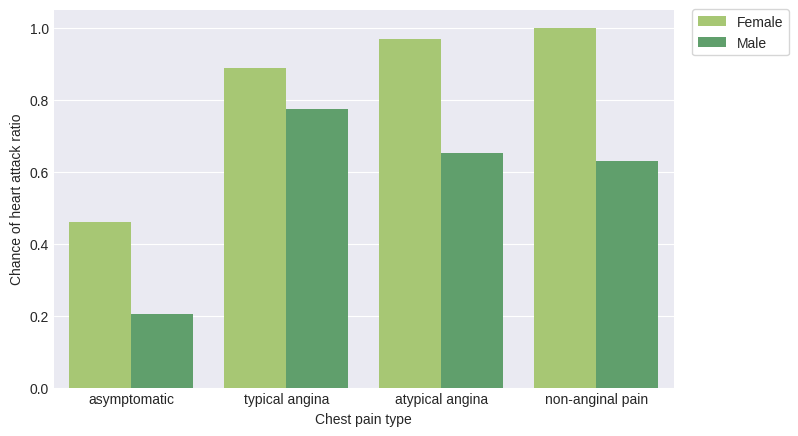

In [17]:
heart_attack_by_sex('cp', 'Chest pain type', ['asymptomatic', 'typical angina', 'atypical angina', 'non-anginal pain'])

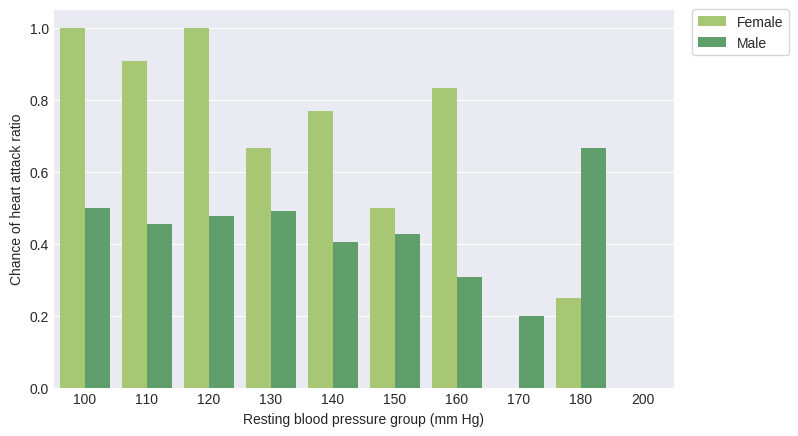

In [18]:
heart_attack_by_sex('trtbps_group', 'Resting blood pressure group (mm Hg)')

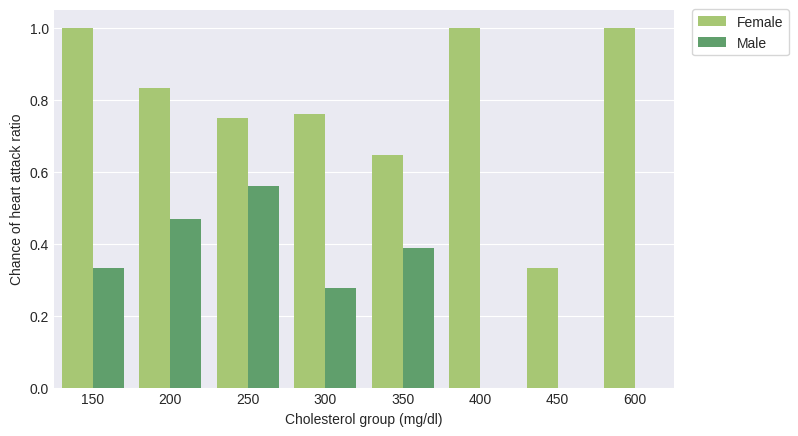

In [19]:
heart_attack_by_sex('chol_group', 'Cholesterol group (mg/dl)')

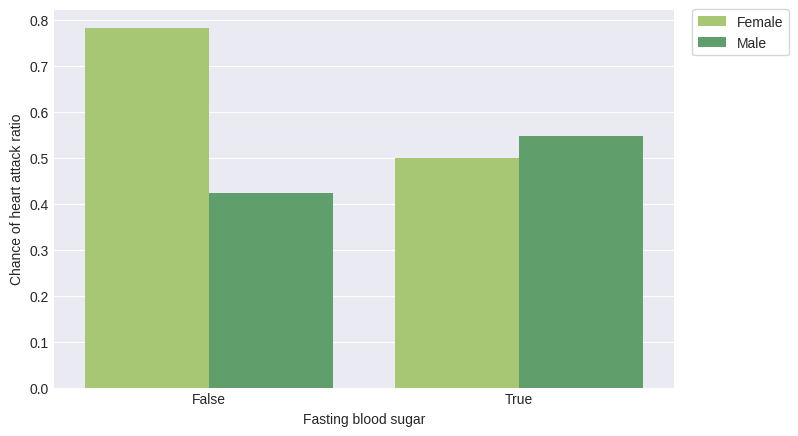

In [20]:
heart_attack_by_sex('fbs', 'Fasting blood sugar', ['False', 'True'])

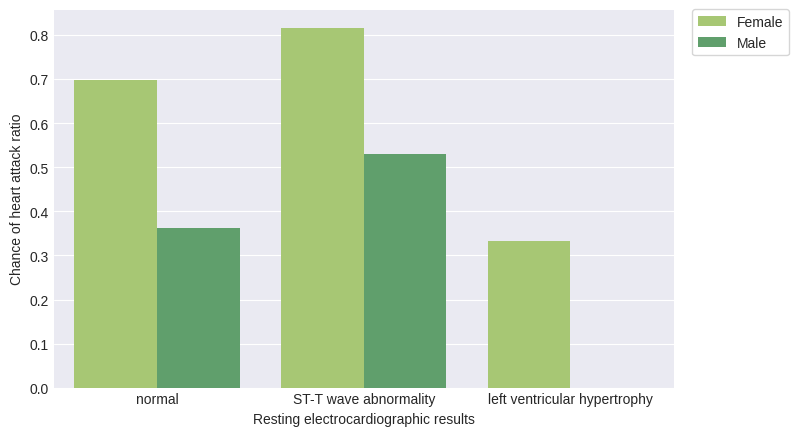

In [21]:
heart_attack_by_sex('restecg', 'Resting electrocardiographic results', ['normal', 'ST-T wave abnormality', 'left ventricular hypertrophy'])

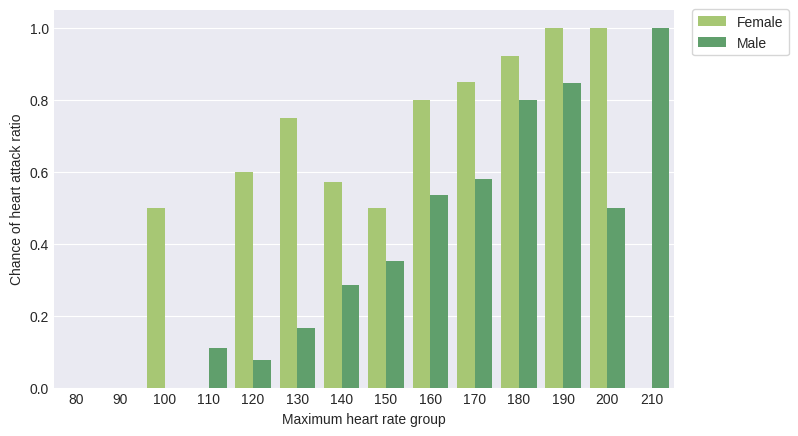

In [22]:
heart_attack_by_sex('thalachh_group', 'Maximum heart rate group')

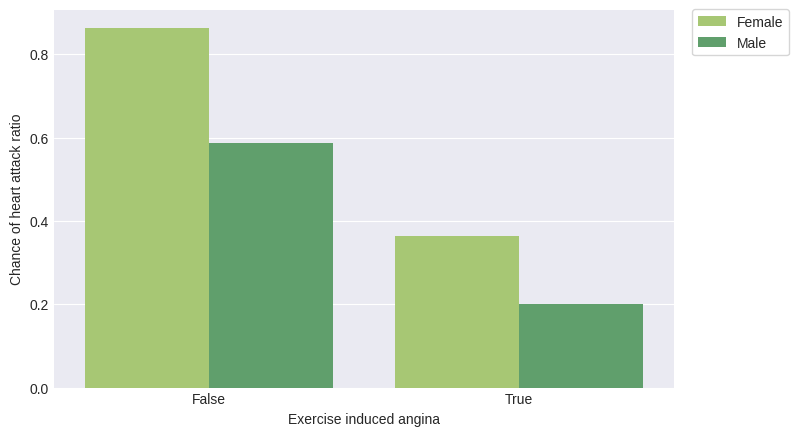

In [23]:
heart_attack_by_sex('exng', 'Exercise induced angina', ['False', 'True'])

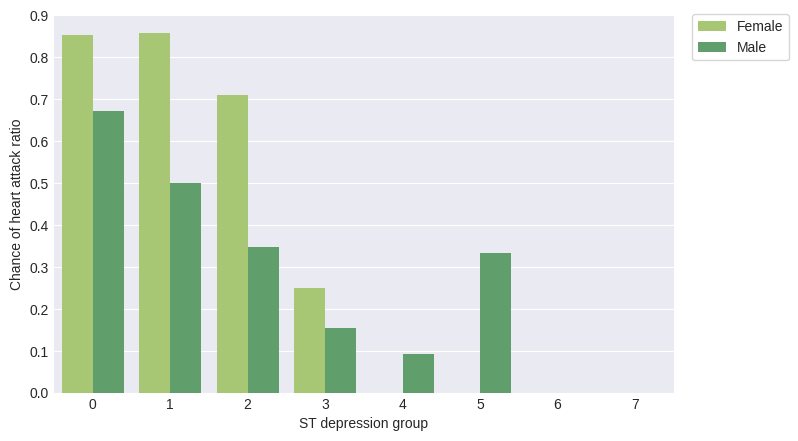

In [24]:
heart_attack_by_sex('oldpeak_group', 'ST depression group')

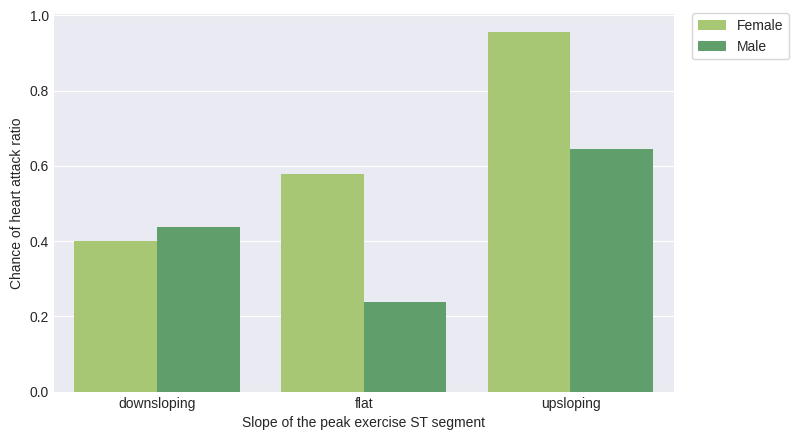

In [25]:
heart_attack_by_sex('slp', 'Slope of the peak exercise ST segment', ['downsloping', 'flat', 'upsloping'])

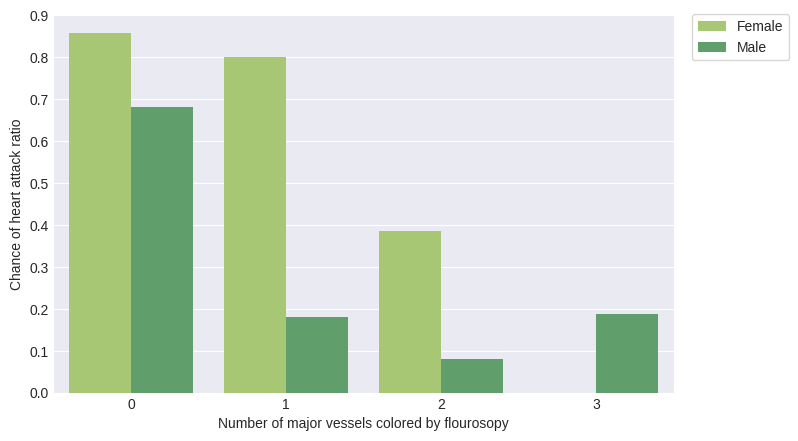

In [26]:
heart_attack_by_sex('caa', 'Number of major vessels colored by flourosopy')

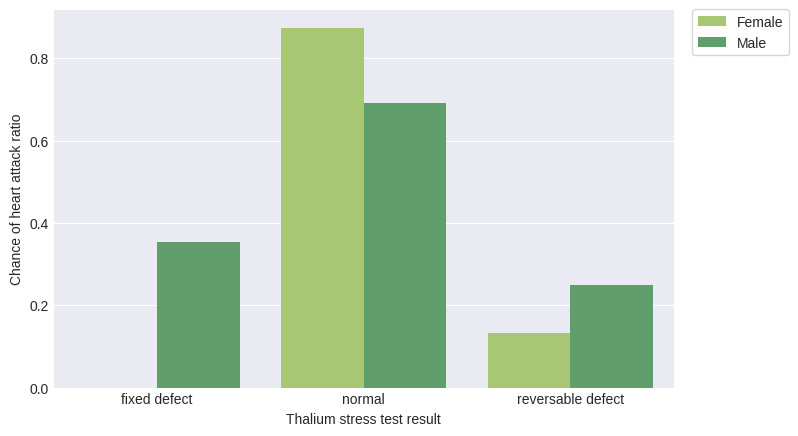

In [27]:
heart_attack_by_sex('thall', 'Thalium stress test result', ['fixed defect', 'normal', 'reversable defect'])

# Reformat data

## Train and test split

In [28]:
df.drop(['age_group', 'trtbps_group', 'chol_group', 'thalachh_group', 'oldpeak_group'], axis=1, inplace=True)

X = df.drop('output', axis=1)
y = df['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Scaling

In [29]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## Datasets

In [30]:
dataset_X_train = Dataset.from_tensor_slices(X_train)
dataset_X_test  = Dataset.from_tensor_slices(X_test)
dataset_y_train = Dataset.from_tensor_slices(y_train)
dataset_y_test  = Dataset.from_tensor_slices(y_test)

dataset_train = Dataset.zip((dataset_X_train, dataset_y_train))
dataset_test  = Dataset.zip((dataset_X_test, dataset_y_test))

dataset_train = dataset_train.batch(BATCH_SIZE).prefetch(AUTOTUNE)
dataset_test  = dataset_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Classification models

In [31]:
evaluations = [None] * 10

## Model 0: KNN

In [32]:
%%time

knn = KNeighborsClassifier(n_neighbors=12)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

CPU times: user 6.22 ms, sys: 0 ns, total: 6.22 ms
Wall time: 12.6 ms


              precision    recall  f1-score   support

           0       0.90      0.84      0.87        32
           1       0.83      0.89      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



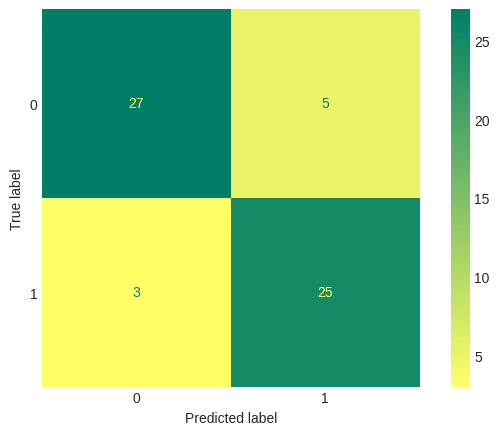

In [33]:
evaluations[0] = evaluate_model(y_test, y_pred, True)

In [34]:
evaluations[0]

{'accuracy': 0.8666666666666667,
 'precision': 0.868888888888889,
 'recall': 0.8666666666666667,
 'f1-score': 0.8668149796069708}

## Model 1: Ridge

In [35]:
%%time

rid = RidgeClassifier(alpha=0.0, fit_intercept=False, random_state=SEED)

rid.fit(X_train, y_train)

y_pred = rid.predict(X_test)

CPU times: user 3.15 ms, sys: 30 µs, total: 3.18 ms
Wall time: 3.2 ms


              precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.81      0.89      0.85        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



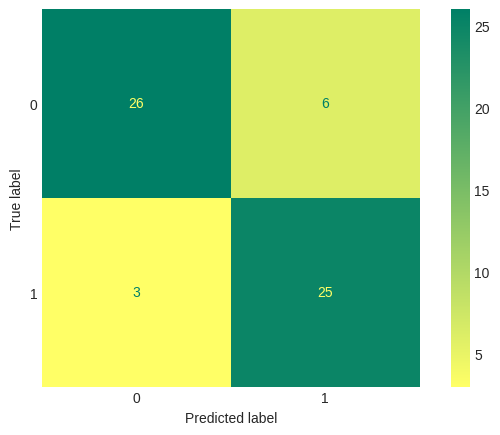

In [36]:
evaluations[1] = evaluate_model(y_test, y_pred, True)

In [37]:
evaluations[1]

{'accuracy': 0.85,
 'precision': 0.8545050055617353,
 'recall': 0.85,
 'f1-score': 0.8501250347318698}

## Model 2: SVM

In [38]:
%%time

svm = SVC(C=4.0, kernel='sigmoid', random_state=SEED)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

CPU times: user 5.37 ms, sys: 1.88 ms, total: 7.25 ms
Wall time: 7.76 ms


              precision    recall  f1-score   support

           0       0.93      0.84      0.89        32
           1       0.84      0.93      0.88        28

    accuracy                           0.88        60
   macro avg       0.88      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60



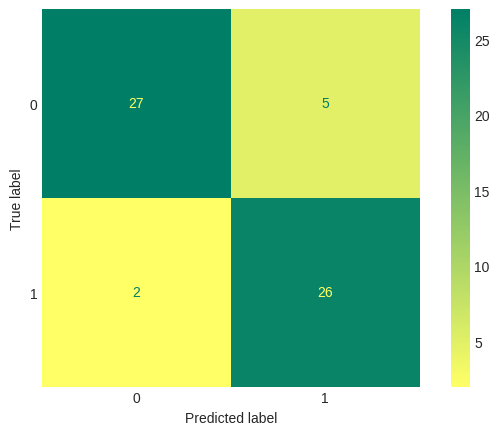

In [39]:
evaluations[2] = evaluate_model(y_test, y_pred, True)

In [40]:
evaluations[2]

{'accuracy': 0.8833333333333333,
 'precision': 0.8879495736002966,
 'recall': 0.8833333333333333,
 'f1-score': 0.8834305825692323}

## Model 3: Multi-layer Perceptron

In [41]:
%%time

mlp = MLPClassifier(hidden_layer_sizes=120, activation='relu', solver='sgd', learning_rate_init=0.001, max_iter=700, random_state=SEED)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

CPU times: user 1.65 s, sys: 1.59 s, total: 3.24 s
Wall time: 4.56 s


              precision    recall  f1-score   support

           0       0.93      0.81      0.87        32
           1       0.81      0.93      0.87        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



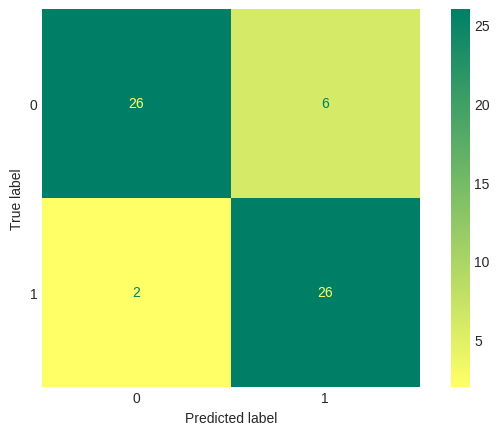

In [42]:
evaluations[3] = evaluate_model(y_test, y_pred, True)

In [43]:
evaluations[3]

{'accuracy': 0.8666666666666667,
 'precision': 0.8744047619047619,
 'recall': 0.8666666666666667,
 'f1-score': 0.8666666666666667}

## Model 4: Dense

In [44]:
%%time

tf.random.set_seed(SEED)

tfd = Sequential()

[tfd.add(Dense(units=LAYER_UNITS, kernel_initializer=LAYER_INITIALIZER, activation=LAYER_ACTIVATION)) for _ in range(LAYERS)]
tfd.add(Dense(units=OUTPUT_UNITS, activation=OUTPUT_ACTIVATION))

tfd.compile(loss=LOSS,
            optimizer=OPTIMIZER(learning_rate=LEARNING_RATE),
            metrics=METRICS)

tfd.fit(dataset_train,
        epochs=EPOCHS,
        validation_data=dataset_test,
        callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
                   ReduceLROnPlateau(monitor='val_loss', patience=50)],
        verbose=0)

y_pred = tf.round(tfd.predict(dataset_test, verbose=0))

CPU times: user 22.2 s, sys: 2.07 s, total: 24.3 s
Wall time: 28 s


              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.80      0.86      0.83        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



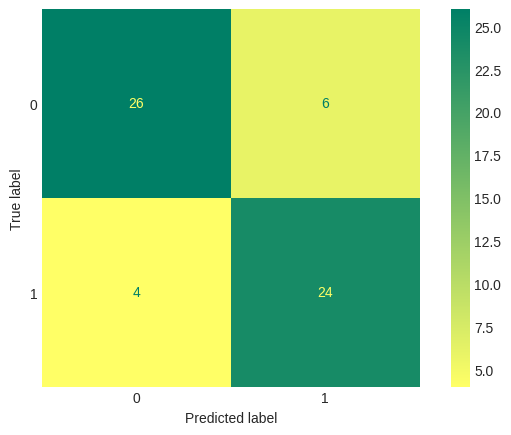

In [45]:
evaluations[4] = evaluate_model(y_test, y_pred, True)

In [46]:
evaluations[4]

{'accuracy': 0.8333333333333334,
 'precision': 0.8355555555555557,
 'recall': 0.8333333333333334,
 'f1-score': 0.8335187245087134}

## Model 5: Ensemble

In [47]:
%%time

ensemble_models = get_ensemble(train_data=dataset_train, validation_data=dataset_test, n_models=10)

CPU times: user 2min 48s, sys: 13.5 s, total: 3min 1s
Wall time: 2min 48s


In [48]:
ensemble_preds = get_preds(ensemble_models=ensemble_models, validation_data=dataset_test)

y_pred = tf.round(tf.reduce_mean(ensemble_preds, axis=0))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.81      0.89      0.85        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



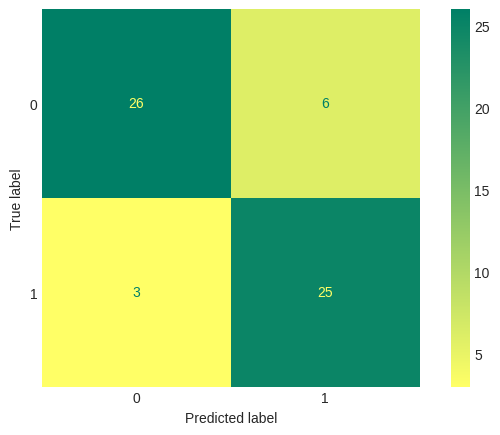

In [49]:
evaluations[5] = evaluate_model(y_test, y_pred, True)

In [50]:
evaluations[5]

{'accuracy': 0.85,
 'precision': 0.8545050055617353,
 'recall': 0.85,
 'f1-score': 0.8501250347318698}

# Comparing models

In [51]:
df_evaluations = pd.DataFrame([e for e in evaluations if e is not None])
df_evaluations.T

,0,1,2,3,4,5
accuracy,0.866667,0.850000,0.883333,0.866667,0.833333,0.850000
precision,0.868889,0.854505,0.887950,0.874405,0.835556,0.854505
recall,0.866667,0.850000,0.883333,0.866667,0.833333,0.850000
f1-score,0.866815,0.850125,0.883431,0.866667,0.833519,0.850125


In [52]:
# Recall is a better index for medical research, because penalizes false negatives.

df_evaluations['recall'].sort_values(ascending=False)

2    0.883333
0    0.866667
3    0.866667
1    0.850000
5    0.850000
4    0.833333
Name: recall, dtype: float64